In [2]:
%pylab inline
from octopus import orbit_cm
from pygadgetreader import *
from octopus import profiles
from octopus import shapes
import biff
from astropy import constants
from astropy import units as u

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
font = {'size':16, 'family':'serif'}
matplotlib.rc('font', **font)

In [4]:
G_c = constants.G
G_c = G_c.to(u.kiloparsec**3 / (u.s**2 * u.Msun)) # 
print G_c

4.51835939627e-39 kpc3 / (s2 solMass)


## Objective: 
    
1. Found the most bounded particles of the LMC
2. What is the potential of that inner region in the outer regions

In [5]:
# Orbit of the N-body simulation
lmc_orbit = np.loadtxt('LMC_orbit/orbits/LMC6_H1.txt')

In [6]:
# Path to snaps
lmc_path = '../data/LMCMW/MWmLMC6/H1/'
lmc_snap = 'MWfLMC6H1'
N_snaps = 120

In [160]:
def mw_particles(xyz, vxyz, pot, ids, M, N_halo):
    id_cut = np.sort(ids)[N_halo]
    index_mw = np.where(ids<id_cut)[0]
    index_lmc = np.where(ids>=id_cut)[0]
    LMC_pos = xyz[index_lmc]
    LMC_vel = vxyz[index_lmc]
    LMC_pot = pot[index_lmc]
    LMC_ids = ids[index_lmc]
    LMC_mass = M[index_lmc]
    #index_cut = np.where(np.sqrt(LMC_pos[:,0]**2.0 + LMC_pos[:,1]**2.0 + LMC_pos[:,2]**2.0) <600)[0]
    return xyz[index_mw], vxyz[index_mw], M[index_mw], pot[index_mw], LMC_pos, LMC_vel, LMC_pot, LMC_ids, LMC_mass

In [8]:
def pot_contour(x, y, pot, n_bins):
    x_pot = np.linspace(min(x), max(x), n_bins)
    y_pot = np.linspace(min(y), max(y), n_bins)
    pot_grid = np.zeros((n_bins,  n_bins))

    for i in range(1,n_bins):
        for j in range(1,n_bins):
            index = np.where((x<x_pot[i]) & (x>x_pot[i-1]) & (y<y_pot[j]) & (y>y_pot[j-1]))[0]
            pot_grid[i][j] = np.mean(pot[index])
    return x_pot, y_pot, pot_grid

In [9]:
#Function that returns the radius at which the LMC is still spherical!
def sphere_radius(x,y,z):
    r = np.linspace(1, 300, 100)
    s=1
    q=1
    i =0
    while ((np.abs(s-1)< 0.1) & (np.abs(q-1)<0.1) & (i<100)):
        s, q = shapes.iterate_volume(x, y, z, r[i], 1E-2)
        i+=1
    return r[i-2]

In [162]:
def MWLMC_all(MW_pos, LMC_pos, MW_M, LMC_M, MW_pot, LMC_pot):
    MWLMC = np.concatenate((MW_pos, LMC_pos), axis=0)
    MWLMC_M = np.concatenate((MW_M, LMC_M), axis=0)
    MWLMC_pot = np.concatenate((MW_pot, LMC_pot), axis=0)
    return MWLMC, MWLMC_M, MWLMC_pot

In [18]:
## Code taken from (https://github.com/adrn/biff/blob/master/notebooks/Plummer%20test.ipynb)
def STnlm(xyz, mass, rs, n_max, l_max):
    nmax = n_max
    lmax = l_max

    Snlm = np.zeros((nmax+1,lmax+1,lmax+1))
    Tnlm = np.zeros((nmax+1,lmax+1,lmax+1))

    nlms = []

    for n in range(nmax+1):
        for l in range(lmax+1):
            for m in range(l+1):
                nlms.append([n,l,m])

    for nlm in nlms:
        n,l,m = nlm
        S,T = biff.compute_coeffs_discrete(np.double(xyz), np.double(mass/100.0), nlm, rs)
        Snlm[n,l,m] = S
        Tnlm[n,l,m] = T
    return Snlm, Tnlm, nlms

In [165]:
# Function that returns the LMC_inner particles, the mass of those particles and
# an array of masses of the lenght of the totoal LMC particles with M=0 for those
# particles outside the radius of the inner LMC particles
def mask(LMC_xyz, xcm, ycm, zcm, r, M, pot):
    index_mask = np.where(np.sqrt((LMC_xyz[:,0]-xcm)**2.0 + (LMC_xyz[:,1]-ycm)**2.0 + (LMC_xyz[:,2]-zcm)**2.0)<r)[0]
    index_out = np.where(np.sqrt((LMC_xyz[:,0]-xcm)**2.0 + (LMC_xyz[:,1]-ycm)**2.0 + (LMC_xyz[:,2]-zcm)**2.0)>=r)[0]
    # Delete positions of the inner LMC particles
    #mask_x = np.delete(LMC_xyz[:,0],index_mask)
    #mask_y = np.delete(LMC_xyz[:,1],index_mask)
    #mask_z = np.delete(LMC_xyz[:,2],index_mask)
    # Make new array with the inner LMC particles
    #LMC_mask = np.zeros((len(mask_x),3))
    #LMC_mask[:,0] = mask_x
    #LMC_mask[:,1] = mask_y
    #LMC_mask[:,2] = mask_z
    # Setting to 0 the mass of particles outside the spherical halo
    # Mass of the particles outside r the one that are in the inner part are ==0
    M_out = np.delete(M, index_mask)
    #M_out[index_out] = 0.0
    return LMC_xyz[index_out], LMC_xyz[index_mask], M[index_out], M[index_mask], pot[index_out], pot[index_mask]
    

In [262]:
def main(lmc_path, lmc_snap, N_i, N_f, lmc_orbit):
    # For every snapshot
    for i in range(N_i, N_f+1):
        # Reading snapshot
        pos = readsnap(lmc_path + lmc_snap + '_{:03d}'.format(i), 'pos', 'dm')
        M = readsnap(lmc_path + lmc_snap + '_{:03d}'.format(i), 'mass', 'dm')
        vel = readsnap(lmc_path + lmc_snap + '_{:03d}'.format(i), 'vel', 'dm')
        pot = readsnap(lmc_path + lmc_snap + '_{:03d}'.format(i), 'pot', 'dm')
        pids = readsnap(lmc_path + lmc_snap + '_{:03d}'.format(i), 'pid', 'dm')
        # Distinguish between MW and LMC particles
        MW_pos, MW_vel, MW_mass, MW_pot, LMC_pos, LMC_vel, LMC_pot, LMC_ids, LMC_mass = mw_particles(pos, vel, pot, pids, M, 1000000)
        # Centering LMC particles at their CM
        LMC_cx = LMC_pos[:,0] - lmc_orbit[i,2]
        LMC_cy = LMC_pos[:,1] - lmc_orbit[i,3]
        LMC_cz = LMC_pos[:,2] - lmc_orbit[i,4]
        print 'finding the rcut'
        r_cut = sphere_radius(LMC_cx, LMC_cy, LMC_cz)
        print 'masking'
        LMC_out, LMC_inn, M_out, M_inn, Pot_out, Pot_inn = mask(LMC_pos, lmc_orbit[i,2], lmc_orbit[i,3], lmc_orbit[i,4], 
                                              r_cut, LMC_mass, LMC_pot)
        print np.shape(MW_mass), np.shape(M_inn)
        pos_out, mass_out, pot_out = MWLMC_all(MW_pos, LMC_out, MW_mass, M_out, MW_pot, Pot_out)
        pot_factor = G_c/43007.1*1E10 
        print min(pot) * pot_factor
    #print max(np.abs(LMC_pot)) * pot_factor
    return pos_out, mass_out, LMC_inn, M_inn, MW_mass, pot_out * pot_factor, Pot_inn * pot_factor

In [263]:
MWLMC, MWLMC_M, LMC_inn, M_inn, MW_mass, pot_out, pot_inn = main(lmc_path, lmc_snap, 1, 1, lmc_orbit)

finding the rcut
masking
(1000000,) (436653,)
-2.5475994806e-26 kpc3 / (s2 solMass)


In [168]:
print len(MWLMC_M), len(MWLMC)
print len(LMC_inn), len(M_inn)

1063347 1063347
436653 436653


In [169]:
print len(MWLMC)

1063347


## IDEA: 

How to compute the potential from the inner LMC outside the LMC? 

Compute the Snlm Tnlm coefficients of the inner LMC (in wich the lmc is spherical) and compute
the potential in all the positions without taking the inner particles. 

In [331]:
r_s = 30.0
r_sMW = 40.85
M_inn_t = sum(M_inn)*10**10
M_out_t = sum(MWLMC_M)*10**10

# centering in the LMC CM
LMC_inn_xcm = LMC_inn[:,0] - lmc_orbit[1,2]
LMC_inn_ycm = LMC_inn[:,1] - lmc_orbit[1,3]
LMC_inn_zcm = LMC_inn[:,2] - lmc_orbit[1,4]

LMC_inn_cm = np.zeros((len(LMC_inn),3))
LMC_inn_cm[:,0] = LMC_inn_xcm
LMC_inn_cm[:,1] = LMC_inn_ycm
LMC_inn_cm[:,2] = LMC_inn_zcm


# Centering MW+LMC on the LMC CM
MWLMC_xcm = MWLMC[:,0] - lmc_orbit[1,2]
MWLMC_ycm = MWLMC[:,1] - lmc_orbit[1,3]
MWLMC_zcm = MWLMC[:,2] - lmc_orbit[1,4]

MWLMC_cm = np.zeros((len(MWLMC),3))
MWLMC_cm[:,0] = MWLMC_xcm
MWLMC_cm[:,1] = MWLMC_ycm
MWLMC_cm[:,2] = MWLMC_zcm


# Centering MW+LMC on the MW CM
MW_xcm = MWLMC[:,0] - lmc_orbit[1,5]
MW_ycm = MWLMC[:,1] - lmc_orbit[1,6]
MW_zcm = MWLMC[:,2] - lmc_orbit[1,7]

MW_cm = np.zeros((len(MWLMC),3))
MW_cm[:,0] = MW_xcm
MW_cm[:,1] = MW_ycm
MW_cm[:,2] = MW_zcm

# centering in the LMC CM
LMC_inn_MWxcm = LMC_inn[:,0] - lmc_orbit[1,5]
LMC_inn_MWycm = LMC_inn[:,1] - lmc_orbit[1,6]
LMC_inn_MWzcm = LMC_inn[:,2] - lmc_orbit[1,7]

LMC_MW_cm = np.zeros((len(LMC_inn_MWcm),3))
LMC_MW_cm[:,0] = LMC_inn_MWxcm
LMC_MW_cm[:,1] = LMC_inn_MWycm
LMC_MW_cm[:,2] = LMC_inn_MWzcm

#Snlm_LMCMW, Tnlm_LMCMW, nlms_LMCMW = STnlm(MWLMC, MWLMC_M, r_sMW, 10, 0)


In [332]:
## Potential of the inner LMC that feels the inner part centered at the origin of the LMC:
LMC_inn_cm_d = LMC_inn_cm.astype(np.double)
Snlm, Tnlm, nlms = STnlm(LMC_inn_cm, M_inn, r_s, 1, 0)
pot_inn_inn = biff.potential(LMC_inn_cm_d, Snlm, Tnlm, 1, 0, G_c.value, M_inn_t, r_s)

## Potential of the outer MW+LMC due to the inner LMC
MWLMC_cm_d = MWLMC_cm.astype(np.double)
#Snlm_out, Tnlm_out, nlms_out = STnlm(MWLMC_cm_d, M_inn, r_s, 10, 0)
pot_out_inn = biff.potential(MWLMC_cm_d, Snlm, Tnlm, 1, 0, G_c.value, M_inn_t, r_s)




In [352]:
## Potential of the outter MW+LMC that feels the outter part centered at the origin of the MW+LMC:
MW_cm_d = MW_cm.astype(np.double)
Snlm_out, Tnlm_out, nlms_out = STnlm(MW_cm, MWLMC_M, r_sMW, 1, 0)#MWLMC_M
pot_out_out = biff.potential(MW_cm_d, Snlm_out, Tnlm_out, 5, 5, G_c.value, M_out_t, r_sMW)

In [353]:
#pot_inn = biff.potential(MWLMC_d, Snlm, Tnlm, 10, 0, G_c.value, M_inn_t, r_s)
LMC_MW_cm_d = LMC_MW_cm.astype(np.double)
pot_inn_out = biff.potential(LMC_MW_cm_d, Snlm_out, Tnlm_out, 5, 5, G_c.value, M_out_t, r_sMW)

In [354]:
print min(pot_out_out)
print min(pot_out_inn)
print min(pot_inn_inn)
print min(pot_inn_out)


-6.97293120719e+13
-4.42648915628e-30
-5.26765933033e-30
-2.19963642062e+13


In [355]:
# Potential of the outter parts due to the outter part + the inner parts
pot_out_t = pot_out_out + pot_out_inn
# Potential of the inner parts due to the outter part + the inner parts
pot_inn_t = pot_inn_out + pot_inn_inn

In [346]:
MWLMC_al = np.concatenate((MWLMC, LMC_inn), axis=0)
pot_all = np.concatenate((pot_out_t, pot_inn_t))
pot_all_NB = np.concatenate((pot_out, pot_inn))

In [335]:
print np.max(np.abs(pot_out_t))/1.0
print np.max(np.abs(pot_inn_t))/1.2

2.79082905303e-28
2.12157835377e-28


In [347]:
# N-body simulations potential
pot_factor = G_c/43007.1*1E10 
#print max(np.abs(pot_inn)) * pot_factor
#print max(np.abs(pot_out)) * pot_factor

factor =1.2

<matplotlib.colorbar.Colorbar instance at 0x7f7d4cf6aa70>

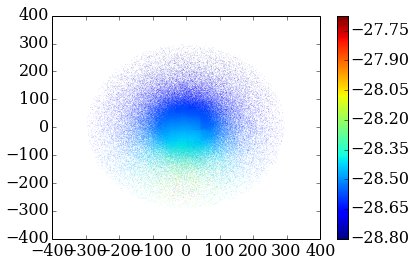

In [322]:
scatter(LMC_inn_cm[:,0] , LMC_inn_cm[:,1], c=np.log10(np.abs(pot_inn_t)/factor), edgecolors='none', s=0.1)
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f7d515cf200>

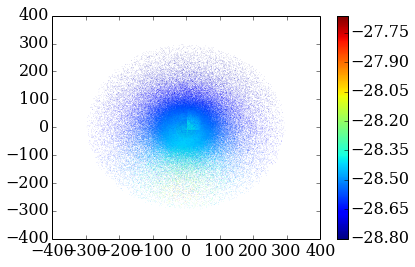

In [213]:
scatter(LMC_inn_cm[:,0] , LMC_inn_cm[:,1], c=np.log10(np.abs(pot_inn)*pot_factor.value), edgecolors='none', s=0.1)
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f7d58321368>

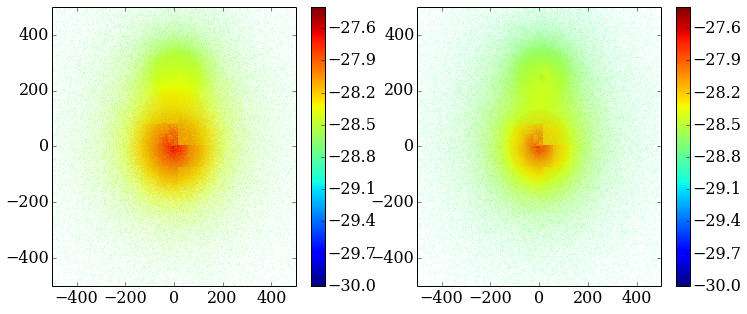

In [288]:
figure(figsize=(12, 5))
subplot(1, 2, 1)
scatter(MWLMC_al[:,0], MWLMC_al[:,1], edgecolors='none', s=0.1, c=np.log10(np.abs(pot_all))
       ,vmin=-30, vmax=-27.4)
xlim(-500, 500)
ylim(-500, 500)
colorbar()

subplot(1, 2, 2)
scatter(MWLMC_al[:,0], MWLMC_al[:,1], edgecolors='none', s=0.1, c=np.log10(np.abs(pot_all_NB))
       ,vmin=-30, vmax=-27.4)
xlim(-500, 500)
ylim(-500, 500)
colorbar()

In [337]:
def truncate(pos, pot):
    index_t = np.where(np.sqrt(pos[:,0]**2.0+ pos[:,1]**2.0 + pos[:,2]**2.0)<600)[0]
    return pos[index_t], pot[index_t]

In [356]:
all_pos_t, all_pot_t = truncate(MWLMC_al, pot_all)
all_pos_t, all_potNB_t = truncate(MWLMC_al, pot_all_NB)

In [357]:
potx, poty, gridpot = pot_contour(all_pos_t[:,0], all_pos_t[:,1], all_pot_t, 100)

In [358]:
potx2, poty2, gridpot2 = pot_contour(all_pos_t[:,0], all_pos_t[:,1], all_potNB_t.value, 100)

In [365]:
levels1 = np.linspace(np.min(all_potNB_t), np.max(all_potNB_t), 20)

(-600, 600)

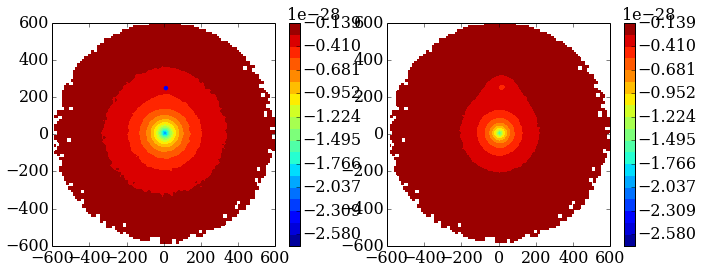

In [380]:

figure(figsize=(11, 4))
subplot(1, 2, 1)
contourf(potx, poty, gridpot.T/1.0, levels=levels1)
xlim(-600, 600)
ylim(-600, 600)
colorbar()
scatter(lmc_orbit[0,2], lmc_orbit[0,3], edgecolors='none')

subplot(1, 2, 2)
contourf(potx2, poty2, gridpot2.T, levels=levels1)
colorbar()
xlim(-600, 600)
ylim(-600, 600)


In [373]:
lmc_orbit[0,2]
lmc_orbit[0,3]

247.827392